In [253]:
# !pip3 install pyarrow
# !pip3 install lightgbm
# !pip3 install optuna

In [254]:
import pandas as pd
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display

In [3]:
def preprocess(df, year):
    df[['Env', 'Hybrid']] = df['id'].str.split(':', expand=True)
    df['Env'] += "_" + str(year)
    df = df.drop('id', axis=1).set_index(['Env', 'Hybrid'])
    return df

In [4]:
%%time

ytrain = pd.read_csv('../output/ytrain.csv').set_index(['Env', 'Hybrid'])
xtrain = pd.read_parquet('../output/kronecker_additive_train.parquet')
xtrain = preprocess(xtrain, year=2020)
xtrain = xtrain.merge(ytrain, on=['Env', 'Hybrid'], how='inner')
ytrain = xtrain['Yield_Mg_ha']
del xtrain['Yield_Mg_ha']

yval = pd.read_csv('../output/yval.csv').set_index(['Env', 'Hybrid'])
xval = pd.read_parquet('../output/kronecker_additive_val.parquet')
xval = preprocess(xval, year=2021)
xval = xval.merge(yval, on=['Env', 'Hybrid'], how='inner')
yval = xval['Yield_Mg_ha']
del xval['Yield_Mg_ha']

CPU times: user 14min 30s, sys: 3min, total: 17min 30s
Wall time: 17min 36s


In [5]:
xtrain

weather_station_lat.2369.DK3IIH6  \
Env       Hybrid                                                
DEH1_2020 B14A/H95                                  -1.007870   
          B14A/MO17                                 -2.618794   
          B14A/OH43                                 -1.091436   
          B37/H95                                   -4.214089   
          B37/MO17                                  -5.779743   
...                                                       ...   
WIH3_2020 W10004_1123/PHP02                          7.057471   
          W10004_1140/PHP02                          6.124553   
          W10004_1143/PHP02                          3.914119   
          W10004_1146/PHP02                          6.426950   
          W10004_1156/PHP02                          7.071355   

                             weather_station_lat.2369.PHN82  \
Env       Hybrid                                              
DEH1_2020 B14A/H95                                -1.837566   
          B14A/MO17                               -2.621807   
          B14A/OH43                               -2.703812   
          B37/H95                                 -5.455722   
          B37/MO17                                -6.227461   
...                                                     ...   
WIH3_2020 W10004_1123/PHP02                        9.981057   
          W10004_1140/PHP02                        8.849074   
          W10004_1143/PHP02                        6.381648   
          W10004_1146/PHP02                        8.690150   
          W10004_1156/PHP02                       10.321447   

                             weather_station_lat.2369.PHZ51  \
Env       Hybrid                                              
DEH1_2020 B14A/H95                                -1.605795   
          B14A/MO17                               -0.972598   
          B14A/OH43                               -2.264200   
          B37/H95                                 -4.986150   
          B37/MO17                                -4.337643   
...                                                     ...   
WIH3_2020 W10004_1123/PHP02                       -6.068796   
          W10004_1140/PHP02                       -5.284921   
          W10004_1143/PHP02                       -7.568028   
          W10004_1146/PHP02                       -5.422780   
          W10004_1156/PHP02                       -5.151226   

                             weather_station_lat.2FACC.DK3IIH6  \
Env       Hybrid                                                 
DEH1_2020 B14A/H95                                   -0.658180   
          B14A/MO17                                  -0.964012   
          B14A/OH43                                  -0.599440   
          B37/H95                                    -1.992894   
          B37/MO17                                   -2.276862   
...                                                        ...   
WIH3_2020 W10004_1123/PHP02                          11.749178   
          W10004_1140/PHP02                           8.710817   
          W10004_1143/PHP02                           9.096639   
          W10004_1146/PHP02                           9.648323   
          W10004_1156/PHP02                          10.094717   

                             weather_station_lat.4N506.DK3IIH6  \
Env       Hybrid                                                 
DEH1_2020 B14A/H95                                    0.631492   
          B14A/MO17                                  -0.132151   
          B14A/OH43                                   0.423410   
          B37/H95                                    -3.038155   
          B37/MO17                                   -3.764019   
...                                                        ...   
WIH3_2020 W10004_1123/PHP02                           7.632591   
          W10004_1140/PHP02                           7.151516   
          W10004_1143/PH

### Training

In [1]:
# %%time

# NCOLS = xtrain.shape[1]
# print('features:', NCOLS)

# best_params = {'feature_fraction': 0.4953070809776986, 'num_leaves': 247, 
#                'bagging_fraction': 0.9866458243098336, 'lambda_l1': 3.680660098838679, 
#                'lambda_l2': 1.1632141265265e-06, 'n_estimators': 232, 'max_depth': 3}
# model = lgbm.LGBMRegressor(random_state=42, **best_params)
# model.fit(xtrain.iloc[:, :NCOLS], ytrain)

# # predict
# ypred = model.predict(xval.iloc[:, :NCOLS])

# # validate
# df_eval = pd.DataFrame()
# df_eval['Env'] = xval.index.get_level_values(0)
# df_eval['ytrue'] = list(yval)
# df_eval['ypred'] = ypred
# rmse_per_group = df_eval.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
# print(rmse_per_group)

# rmse = sum(rmse_per_group) / len(rmse_per_group)
# print('RMSE:', rmse)

In [2]:
# print(r2_score(df_eval['ytrue'], df_eval['ypred']))
# df_eval.plot.scatter('ytrue', 'ypred', figsize=(6, 6));

In [7]:
# max_depth=2 -> RMSE: 2.25325370257595
# max_depth=3 -> RMSE: 2.230505324397102

In [8]:
from sklearn.decomposition import TruncatedSVD

In [184]:
%%time

n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(xtrain)
print(svd.explained_variance_ratio_.sum())

0.9953586892772078
CPU times: user 5min 28s, sys: 10.7 s, total: 5min 38s
Wall time: 5min 39s


In [185]:
%%time

xtrain_svd = pd.DataFrame(svd.transform(xtrain), index=xtrain.index)
xtrain_svd.columns = [f'kron_svd{i}' for i in range(n_components)]

xval_svd = pd.DataFrame(svd.transform(xval), index=xval.index)
xval_svd.columns = [f'kron_svd{i}' for i in range(n_components)]

CPU times: user 57.3 s, sys: 970 µs, total: 57.3 s
Wall time: 57.5 s


In [186]:
# %%time

# from sklearn.svm import LinearSVR

# model2 = LinearSVR(random_state=42, max_iter=5000)
# model2.fit(xtrain_svd, ytrain)

# # predict
# ypred2 = model2.predict(xval_svd)

# # validate
# df_eval2 = pd.DataFrame()
# df_eval2['Env'] = xval_svd.index.get_level_values(0)
# df_eval2['ytrue'] = list(yval)
# df_eval2['ypred'] = ypred2
# rmse_per_group2 = df_eval2.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
# # print(rmse_per_group2)

# rmse2 = sum(rmse_per_group2) / len(rmse_per_group2)
# print('RMSE:', rmse2)

In [187]:
xtrain_lag = pd.read_csv('../output/xtrain.csv', usecols=lambda x: 'yield_lag' in x or x in ['Env', 'Hybrid']).set_index(['Env', 'Hybrid'])
xval_lag = pd.read_csv('../output/xval.csv', usecols=lambda x: 'yield_lag' in x or x in ['Env', 'Hybrid']).set_index(['Env', 'Hybrid'])
xtrain_svd = xtrain_svd.merge(xtrain_lag, on=['Env', 'Hybrid'], how='inner')
xval_svd = xval_svd.merge(xval_lag, on=['Env', 'Hybrid'], how='inner')

In [188]:
xtrain_svd

kron_svd0     kron_svd1     kron_svd2  \
Env       Hybrid                                                        
DEH1_2020 B14A/H95             709.053009  -3345.149715   2005.585009   
          B14A/MO17           5880.056458  -5823.276578   5595.856179   
          B14A/OH43            340.571897  -6599.946344   3759.077266   
          B37/H95            -1457.096478  -4011.181244   3688.293012   
          B37/MO17            3694.017087  -6486.706019   7260.578456   
...                                   ...           ...           ...   
WIH3_2020 W10004_1123/PHP02 -20300.209466  40164.583711  10592.273859   
          W10004_1140/PHP02 -18429.430028  33978.459661   8692.844851   
          W10004_1143/PHP02 -18925.493349  34037.374161  10821.036005   
          W10004_1146/PHP02 -18073.106753  34738.854272  10116.546210   
          W10004_1156/PHP02 -19810.305465  34267.716562   8581.293496   

                               kron_svd3     kron_svd4    kron_svd5  \
Env       Hybrid                                                      
DEH1_2020 B14A/H95            308.199408   1166.379681   -15.876066   
          B14A/MO17          -608.270282   2506.520689    37.596511   
          B14A/OH43           866.011085   1905.456239   -48.490717   
          B37/H95             884.307320 -18936.667615    81.912352   
          B37/MO17            -27.190738 -17437.783007   134.085650   
...                                  ...           ...          ...   
WIH3_2020 W10004_1123/PHP02 -7000.991428   -708.106554 -9027.661259   
          W10004_1140/PHP02 -6318.937809   1760.533905 -7829.699286   
          W10004_1143/PHP02 -6505.100710  -6300.291993 -7951.329510   
          W10004_1146/PHP02 -6218.710303   1072.092603 -7934.251671   
          W10004_1156/PHP02 -6750.300988   1643.747388 -8079.339332   

                                kron_svd6     kron_svd7     kron_svd8  \
Env       Hybrid                                                        
DEH1_2020 B14A/H95              54.457018  -2039.714959   7166.727516   
          B14A/MO17             44.557171  -8577.970418  18284.478370   
          B14A/OH43            121.162037  -2126.175538   8282.797514   
          B37/H95             -850.708874  10032.644936   6159.191220   
          B37/MO17            -852.634927   3344.337603  17221.375686   
...                                   ...           ...           ...   
WIH3_2020 W10004_1123/PHP02  35496.368768  -1147.134094   -606.998851   
          W10004_1140/PHP02  30349.789898   1581.032386   2269.677465   
          W10004_1143/PHP02  30595.056717   1362.607082   2298.776698   
          W10004_1146/PHP02  31059.512431  -1331.708873    333.684801   
          W10004_1156/PHP02  30908.638212  -1354.700042    525.468135   

                               kron_svd9  ...  kron_svd96  kron_svd97  \
Env       Hybrid                          ...                           
DEH1_2020 B14A/H95             92.873134  ... -229.970611  602.120149   
          B14A/MO17          1141.251448  ... -273.329000   84.121809   
          B14A/OH43           227.177410  ... -302.033371 -335.471062   
          B37/H95            -336.867730  ...  394.342672  309.671249   
          B37/MO17            708.265933  ...  347.287627 -205.154835   
...                                  ...  ...         ...         ...   
WIH3_2020 W10004_1123/PHP02   735.251171  ... -573.616181  -80.490390   
          W10004_1140/PHP02   266.250041  ...  444.870235  -17.443303   
          W10004_1143/PHP02  1291.608054  ...  300.925015 -215.954379   
          W10004_1146/PHP02   569.090921  ...  198.941710 -130.794861   
          W10004_1156/PHP02   169.747100  ...   81.125904 -380.517029   

                             kron_svd98   kron_svd99  mean_yield_lag_2  \
Env       Hybrid                                                         
DEH1_2020 B14A/H95            22.897197 -1059.957935         10.056423   
          B14A/MO17          -49.118

In [189]:
import optuna

In [215]:
def objective(trial):
    """
    https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258
    """
    params = {

#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.0, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'deterministic': True,
        'random_state': 42
    }
    
    model2 = lgbm.LGBMRegressor(**params)
    model2.fit(xtrain_svd, ytrain)

    # predict
    ypred2 = model2.predict(xval_svd)

    # validate
    df_eval2 = pd.DataFrame()
    df_eval2['Env'] = xval_svd.index.get_level_values(0)
    df_eval2['ytrue'] = list(yval)
    df_eval2['ypred'] = ypred2
    rmse_per_group2 = df_eval2.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
    # print(rmse_per_group2)

    rmse2 = sum(rmse_per_group2) / len(rmse_per_group2)
    return rmse2


study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best RMSE:', study.best_value)

[I 2023-01-31 15:07:31,632] A new study created in memory with name: no-name-31552917-ed18-4fb2-afd8-97552bc34d73


[LightGBM] [Warning] lambda_l1 is set=0.0024430162614261413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024430162614261413
[LightGBM] [Warning] bagging_fraction is set=0.7855951534491241, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7855951534491241
[LightGBM] [Warning] feature_fraction is set=0.49963209507789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49963209507789
[LightGBM] [Warning] lambda_l2 is set=2.5361081166471375e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5361081166471375e-07


[I 2023-01-31 15:07:32,011] Trial 0 finished with value: 2.3516689231623427 and parameters: {'feature_fraction': 0.49963209507789, 'num_leaves': 244, 'bagging_fraction': 0.7855951534491241, 'lambda_l1': 0.0024430162614261413, 'lambda_l2': 2.5361081166471375e-07, 'n_estimators': 55, 'max_depth': 2}. Best is trial 0 with value: 2.3516689231623427.


[LightGBM] [Warning] lambda_l1 is set=1.5320059381854043e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5320059381854043e-08
[LightGBM] [Warning] bagging_fraction is set=0.7664580622368364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7664580622368364
[LightGBM] [Warning] feature_fraction is set=0.8929409166199482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8929409166199482
[LightGBM] [Warning] lambda_l2 is set=5.360294728728285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.360294728728285


[I 2023-01-31 15:07:33,408] Trial 1 finished with value: 2.303270291472141 and parameters: {'feature_fraction': 0.8929409166199482, 'num_leaves': 155, 'bagging_fraction': 0.7664580622368364, 'lambda_l1': 1.5320059381854043e-08, 'lambda_l2': 5.360294728728285, 'n_estimators': 252, 'max_depth': 3}. Best is trial 1 with value: 2.303270291472141.


[LightGBM] [Warning] lambda_l1 is set=0.00052821153945323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00052821153945323
[LightGBM] [Warning] bagging_fraction is set=0.4433937943676302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4433937943676302
[LightGBM] [Warning] feature_fraction is set=0.3454599737656805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3454599737656805
[LightGBM] [Warning] lambda_l2 is set=7.71800699380605e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.71800699380605e-05


[I 2023-01-31 15:07:34,125] Trial 2 finished with value: 2.2854076933348315 and parameters: {'feature_fraction': 0.3454599737656805, 'num_leaves': 48, 'bagging_fraction': 0.4433937943676302, 'lambda_l1': 0.00052821153945323, 'lambda_l2': 7.71800699380605e-05, 'n_estimators': 94, 'max_depth': 5}. Best is trial 2 with value: 2.2854076933348315.


[LightGBM] [Warning] lambda_l1 is set=0.00012724181576752517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012724181576752517
[LightGBM] [Warning] bagging_fraction is set=0.4930894746349534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4930894746349534
[LightGBM] [Warning] feature_fraction is set=0.3115950885216335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3115950885216335
[LightGBM] [Warning] lambda_l2 is set=0.1165691561324743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1165691561324743


[I 2023-01-31 15:07:34,609] Trial 3 finished with value: 2.2950563493423144 and parameters: {'feature_fraction': 0.3115950885216335, 'num_leaves': 76, 'bagging_fraction': 0.4930894746349534, 'lambda_l1': 0.00012724181576752517, 'lambda_l2': 0.1165691561324743, 'n_estimators': 68, 'max_depth': 4}. Best is trial 2 with value: 2.2854076933348315.


[LightGBM] [Warning] lambda_l1 is set=3.425445902633376e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.425445902633376e-07
[LightGBM] [Warning] bagging_fraction is set=0.6860358815211507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6860358815211507
[LightGBM] [Warning] feature_fraction is set=0.6739316550896339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6739316550896339
[LightGBM] [Warning] lambda_l2 is set=3.850031979199519e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.850031979199519e-08


[I 2023-01-31 15:07:36,478] Trial 4 finished with value: 2.3015410563171277 and parameters: {'feature_fraction': 0.6739316550896339, 'num_leaves': 13, 'bagging_fraction': 0.6860358815211507, 'lambda_l1': 3.425445902633376e-07, 'lambda_l2': 3.850031979199519e-08, 'n_estimators': 286, 'max_depth': 6}. Best is trial 2 with value: 2.2854076933348315.


[LightGBM] [Warning] lambda_l1 is set=0.014391207615728067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014391207615728067
[LightGBM] [Warning] bagging_fraction is set=0.2781376912051071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2781376912051071
[LightGBM] [Warning] feature_fraction is set=0.846717878493169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.846717878493169
[LightGBM] [Warning] lambda_l2 is set=9.148975058772307e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.148975058772307e-05


[I 2023-01-31 15:07:37,053] Trial 5 finished with value: 2.3272118565623994 and parameters: {'feature_fraction': 0.846717878493169, 'num_leaves': 79, 'bagging_fraction': 0.2781376912051071, 'lambda_l1': 0.014391207615728067, 'lambda_l2': 9.148975058772307e-05, 'n_estimators': 45, 'max_depth': 4}. Best is trial 2 with value: 2.2854076933348315.


[LightGBM] [Warning] lambda_l1 is set=0.009176996354542699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009176996354542699
[LightGBM] [Warning] bagging_fraction is set=0.40702398528001354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40702398528001354
[LightGBM] [Warning] feature_fraction is set=0.22751081689217473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22751081689217473
[LightGBM] [Warning] lambda_l2 is set=6.388511557344611e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.388511557344611e-06


[I 2023-01-31 15:07:37,714] Trial 6 finished with value: 2.2648671272314203 and parameters: {'feature_fraction': 0.22751081689217473, 'num_leaves': 233, 'bagging_fraction': 0.40702398528001354, 'lambda_l1': 0.009176996354542699, 'lambda_l2': 6.388511557344611e-06, 'n_estimators': 161, 'max_depth': 4}. Best is trial 6 with value: 2.2648671272314203.


[LightGBM] [Warning] lambda_l1 is set=2.854239907497756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854239907497756
[LightGBM] [Warning] bagging_fraction is set=0.8201062586888916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8201062586888916
[LightGBM] [Warning] feature_fraction is set=0.3478835644204217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3478835644204217
[LightGBM] [Warning] lambda_l2 is set=1.1309571585271483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1309571585271483


[I 2023-01-31 15:07:39,214] Trial 7 finished with value: 2.3754119946715995 and parameters: {'feature_fraction': 0.3478835644204217, 'num_leaves': 249, 'bagging_fraction': 0.8201062586888916, 'lambda_l1': 2.854239907497756, 'lambda_l2': 1.1309571585271483, 'n_estimators': 183, 'max_depth': 6}. Best is trial 6 with value: 2.2648671272314203.


[LightGBM] [Warning] lambda_l1 is set=8.471746987003668e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.471746987003668e-06
[LightGBM] [Warning] bagging_fraction is set=0.23618183112843047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23618183112843047
[LightGBM] [Warning] feature_fraction is set=0.2707940016415356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2707940016415356
[LightGBM] [Warning] lambda_l2 is set=3.148441347423712e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.148441347423712e-05


[I 2023-01-31 15:07:39,982] Trial 8 finished with value: 2.323168563524801 and parameters: {'feature_fraction': 0.2707940016415356, 'num_leaves': 51, 'bagging_fraction': 0.23618183112843047, 'lambda_l1': 8.471746987003668e-06, 'lambda_l2': 3.148441347423712e-05, 'n_estimators': 88, 'max_depth': 6}. Best is trial 6 with value: 2.2648671272314203.


[LightGBM] [Warning] lambda_l1 is set=1.8548894229694903e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8548894229694903e-07
[LightGBM] [Warning] bagging_fraction is set=0.6341568665265989, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6341568665265989
[LightGBM] [Warning] feature_fraction is set=0.4854026613548714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4854026613548714
[LightGBM] [Warning] lambda_l2 is set=0.16587190283399655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16587190283399655


[I 2023-01-31 15:07:40,569] Trial 9 finished with value: 2.351799610938574 and parameters: {'feature_fraction': 0.4854026613548714, 'num_leaves': 73, 'bagging_fraction': 0.6341568665265989, 'lambda_l1': 1.8548894229694903e-07, 'lambda_l2': 0.16587190283399655, 'n_estimators': 31, 'max_depth': 6}. Best is trial 6 with value: 2.2648671272314203.


[LightGBM] [Warning] lambda_l1 is set=0.19237494135966834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19237494135966834
[LightGBM] [Warning] bagging_fraction is set=0.9756296886302929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9756296886302929
[LightGBM] [Warning] feature_fraction is set=0.21641114280259444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21641114280259444
[LightGBM] [Warning] lambda_l2 is set=6.739006603244534e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.739006603244534e-07


[I 2023-01-31 15:07:41,148] Trial 10 finished with value: 2.2266286743467165 and parameters: {'feature_fraction': 0.21641114280259444, 'num_leaves': 182, 'bagging_fraction': 0.9756296886302929, 'lambda_l1': 0.19237494135966834, 'lambda_l2': 6.739006603244534e-07, 'n_estimators': 167, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.11731504557993938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11731504557993938
[LightGBM] [Warning] bagging_fraction is set=0.9966394390611305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9966394390611305
[LightGBM] [Warning] feature_fraction is set=0.20870058074871745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20870058074871745
[LightGBM] [Warning] lambda_l2 is set=8.956408095934925e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.956408095934925e-07


[I 2023-01-31 15:07:41,719] Trial 11 finished with value: 2.257916384046502 and parameters: {'feature_fraction': 0.20870058074871745, 'num_leaves': 185, 'bagging_fraction': 0.9966394390611305, 'lambda_l1': 0.11731504557993938, 'lambda_l2': 8.956408095934925e-07, 'n_estimators': 166, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.39360189438657295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39360189438657295
[LightGBM] [Warning] bagging_fraction is set=0.9961494121373188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9961494121373188
[LightGBM] [Warning] feature_fraction is set=0.21344318692353204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21344318692353204
[LightGBM] [Warning] lambda_l2 is set=7.531727823788722e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.531727823788722e-07


[I 2023-01-31 15:07:42,259] Trial 12 finished with value: 2.3378130119349425 and parameters: {'feature_fraction': 0.21344318692353204, 'num_leaves': 179, 'bagging_fraction': 0.9961494121373188, 'lambda_l1': 0.39360189438657295, 'lambda_l2': 7.531727823788722e-07, 'n_estimators': 209, 'max_depth': 2}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.19208412244124926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19208412244124926
[LightGBM] [Warning] bagging_fraction is set=0.9661743429626015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9661743429626015
[LightGBM] [Warning] feature_fraction is set=0.2055186523473571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2055186523473571
[LightGBM] [Warning] lambda_l2 is set=2.005732281713045e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.005732281713045e-08


[I 2023-01-31 15:07:42,779] Trial 13 finished with value: 2.265692721655805 and parameters: {'feature_fraction': 0.2055186523473571, 'num_leaves': 194, 'bagging_fraction': 0.9661743429626015, 'lambda_l1': 0.19208412244124926, 'lambda_l2': 2.005732281713045e-08, 'n_estimators': 134, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=5.229858459779272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.229858459779272
[LightGBM] [Warning] bagging_fraction is set=0.903131743368793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.903131743368793
[LightGBM] [Warning] feature_fraction is set=0.4267311214977873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4267311214977873
[LightGBM] [Warning] lambda_l2 is set=1.5929224526621622e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5929224526621622e-06


[I 2023-01-31 15:07:43,632] Trial 14 finished with value: 2.2402739485716174 and parameters: {'feature_fraction': 0.4267311214977873, 'num_leaves': 126, 'bagging_fraction': 0.903131743368793, 'lambda_l1': 5.229858459779272, 'lambda_l2': 1.5929224526621622e-06, 'n_estimators': 213, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=8.956867678512117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.956867678512117
[LightGBM] [Warning] bagging_fraction is set=0.8882317447956023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8882317447956023
[LightGBM] [Warning] feature_fraction is set=0.4238147508275065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4238147508275065
[LightGBM] [Warning] lambda_l2 is set=0.0005420509194468828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005420509194468828


[I 2023-01-31 15:07:44,523] Trial 15 finished with value: 2.2272057448955143 and parameters: {'feature_fraction': 0.4238147508275065, 'num_leaves': 125, 'bagging_fraction': 0.8882317447956023, 'lambda_l1': 8.956867678512117, 'lambda_l2': 0.0005420509194468828, 'n_estimators': 226, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=7.2421962493203775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.2421962493203775
[LightGBM] [Warning] bagging_fraction is set=0.8563778025493536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8563778025493536
[LightGBM] [Warning] feature_fraction is set=0.5882481569579695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5882481569579695
[LightGBM] [Warning] lambda_l2 is set=0.0016447293604905234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016447293604905234


[I 2023-01-31 15:07:45,347] Trial 16 finished with value: 2.2877622030853564 and parameters: {'feature_fraction': 0.5882481569579695, 'num_leaves': 124, 'bagging_fraction': 0.8563778025493536, 'lambda_l1': 7.2421962493203775, 'lambda_l2': 0.0016447293604905234, 'n_estimators': 241, 'max_depth': 2}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.3701571298286474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3701571298286474
[LightGBM] [Warning] bagging_fraction is set=0.9000292653213244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000292653213244
[LightGBM] [Warning] feature_fraction is set=0.39617095161223803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39617095161223803
[LightGBM] [Warning] lambda_l2 is set=0.0017482274705964054, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017482274705964054


[I 2023-01-31 15:07:47,081] Trial 17 finished with value: 2.287178578714348 and parameters: {'feature_fraction': 0.39617095161223803, 'num_leaves': 149, 'bagging_fraction': 0.9000292653213244, 'lambda_l1': 0.3701571298286474, 'lambda_l2': 0.0017482274705964054, 'n_estimators': 277, 'max_depth': 5}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.03615794893273959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03615794893273959
[LightGBM] [Warning] bagging_fraction is set=0.7235558323722407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7235558323722407
[LightGBM] [Warning] feature_fraction is set=0.33746378742001476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33746378742001476
[LightGBM] [Warning] lambda_l2 is set=0.00041144117469956245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00041144117469956245


[I 2023-01-31 15:07:47,652] Trial 18 finished with value: 2.2500439626768447 and parameters: {'feature_fraction': 0.33746378742001476, 'num_leaves': 215, 'bagging_fraction': 0.7235558323722407, 'lambda_l1': 0.03615794893273959, 'lambda_l2': 0.00041144117469956245, 'n_estimators': 123, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=1.219556065779806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.219556065779806
[LightGBM] [Warning] bagging_fraction is set=0.8565061005847393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8565061005847393
[LightGBM] [Warning] feature_fraction is set=0.42077358709346574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42077358709346574
[LightGBM] [Warning] lambda_l2 is set=6.7432947603879495e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7432947603879495e-06


[I 2023-01-31 15:07:49,047] Trial 19 finished with value: 2.3324787367737034 and parameters: {'feature_fraction': 0.42077358709346574, 'num_leaves': 113, 'bagging_fraction': 0.8565061005847393, 'lambda_l1': 1.219556065779806, 'lambda_l2': 6.7432947603879495e-06, 'n_estimators': 199, 'max_depth': 5}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=1.693259615774155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.693259615774155
[LightGBM] [Warning] bagging_fraction is set=0.9338607576952394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9338607576952394
[LightGBM] [Warning] feature_fraction is set=0.2908346669047859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2908346669047859
[LightGBM] [Warning] lambda_l2 is set=0.003906253501269363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003906253501269363


[I 2023-01-31 15:07:49,672] Trial 20 finished with value: 2.262388336069726 and parameters: {'feature_fraction': 0.2908346669047859, 'num_leaves': 156, 'bagging_fraction': 0.9338607576952394, 'lambda_l1': 1.693259615774155, 'lambda_l2': 0.003906253501269363, 'n_estimators': 240, 'max_depth': 2}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=7.814525815977844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.814525815977844
[LightGBM] [Warning] bagging_fraction is set=0.9154028319577739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9154028319577739
[LightGBM] [Warning] feature_fraction is set=0.44667278909235303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44667278909235303
[LightGBM] [Warning] lambda_l2 is set=1.3260275582914776e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3260275582914776e-07


[I 2023-01-31 15:07:50,562] Trial 21 finished with value: 2.245960797556528 and parameters: {'feature_fraction': 0.44667278909235303, 'num_leaves': 106, 'bagging_fraction': 0.9154028319577739, 'lambda_l1': 7.814525815977844, 'lambda_l2': 1.3260275582914776e-07, 'n_estimators': 218, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=8.064388155277886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.064388155277886
[LightGBM] [Warning] bagging_fraction is set=0.8796761159928412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8796761159928412
[LightGBM] [Warning] feature_fraction is set=0.5413633388532098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5413633388532098
[LightGBM] [Warning] lambda_l2 is set=2.5560287198268226e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5560287198268226e-06


[I 2023-01-31 15:07:51,438] Trial 22 finished with value: 2.260681954561392 and parameters: {'feature_fraction': 0.5413633388532098, 'num_leaves': 138, 'bagging_fraction': 0.8796761159928412, 'lambda_l1': 8.064388155277886, 'lambda_l2': 2.5560287198268226e-06, 'n_estimators': 185, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=1.2055145761052841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2055145761052841
[LightGBM] [Warning] bagging_fraction is set=0.807302856335356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.807302856335356
[LightGBM] [Warning] feature_fraction is set=0.3981571295359069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3981571295359069
[LightGBM] [Warning] lambda_l2 is set=1.7657517855762206e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7657517855762206e-05


[I 2023-01-31 15:07:52,540] Trial 23 finished with value: 2.269456468399343 and parameters: {'feature_fraction': 0.3981571295359069, 'num_leaves': 105, 'bagging_fraction': 0.807302856335356, 'lambda_l1': 1.2055145761052841, 'lambda_l2': 1.7657517855762206e-05, 'n_estimators': 223, 'max_depth': 4}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.11348674670431042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11348674670431042
[LightGBM] [Warning] bagging_fraction is set=0.9190633380253411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9190633380253411
[LightGBM] [Warning] feature_fraction is set=0.45229325130236087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45229325130236087
[LightGBM] [Warning] lambda_l2 is set=2.3312702276997374e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3312702276997374e-06


[I 2023-01-31 15:07:53,206] Trial 24 finished with value: 2.248297585495069 and parameters: {'feature_fraction': 0.45229325130236087, 'num_leaves': 162, 'bagging_fraction': 0.9190633380253411, 'lambda_l1': 0.11348674670431042, 'lambda_l2': 2.3312702276997374e-06, 'n_estimators': 135, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.9049305122388587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9049305122388587
[LightGBM] [Warning] bagging_fraction is set=0.9965154878225136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9965154878225136
[LightGBM] [Warning] feature_fraction is set=0.2754678006312852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2754678006312852
[LightGBM] [Warning] lambda_l2 is set=1.6780257069494478e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6780257069494478e-07


[I 2023-01-31 15:07:53,849] Trial 25 finished with value: 2.249870462345708 and parameters: {'feature_fraction': 0.2754678006312852, 'num_leaves': 209, 'bagging_fraction': 0.9965154878225136, 'lambda_l1': 0.9049305122388587, 'lambda_l2': 1.6780257069494478e-07, 'n_estimators': 262, 'max_depth': 2}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=9.48917500724616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.48917500724616
[LightGBM] [Warning] bagging_fraction is set=0.8486711670603425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8486711670603425
[LightGBM] [Warning] feature_fraction is set=0.3794764954931881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3794764954931881
[LightGBM] [Warning] lambda_l2 is set=1.730786151343309e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.730786151343309e-08


[I 2023-01-31 15:07:54,813] Trial 26 finished with value: 2.254586276245327 and parameters: {'feature_fraction': 0.3794764954931881, 'num_leaves': 132, 'bagging_fraction': 0.8486711670603425, 'lambda_l1': 9.48917500724616, 'lambda_l2': 1.730786151343309e-08, 'n_estimators': 185, 'max_depth': 4}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.04909547717893523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04909547717893523
[LightGBM] [Warning] bagging_fraction is set=0.7517578079709415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7517578079709415
[LightGBM] [Warning] feature_fraction is set=0.5281522024162479, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5281522024162479
[LightGBM] [Warning] lambda_l2 is set=1.3367906945085835e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3367906945085835e-05


[I 2023-01-31 15:07:55,788] Trial 27 finished with value: 2.2412783708688937 and parameters: {'feature_fraction': 0.5281522024162479, 'num_leaves': 95, 'bagging_fraction': 0.7517578079709415, 'lambda_l1': 0.04909547717893523, 'lambda_l2': 1.3367906945085835e-05, 'n_estimators': 228, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.5461602600174729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5461602600174729
[LightGBM] [Warning] bagging_fraction is set=0.9370758964556462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9370758964556462
[LightGBM] [Warning] feature_fraction is set=0.6397252338697575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6397252338697575
[LightGBM] [Warning] lambda_l2 is set=0.00010446871991266757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010446871991266757


[I 2023-01-31 15:07:56,640] Trial 28 finished with value: 2.2474420895564773 and parameters: {'feature_fraction': 0.6397252338697575, 'num_leaves': 169, 'bagging_fraction': 0.9370758964556462, 'lambda_l1': 0.5461602600174729, 'lambda_l2': 0.00010446871991266757, 'n_estimators': 157, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.004398832961306833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004398832961306833
[LightGBM] [Warning] bagging_fraction is set=0.7866039908652767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7866039908652767
[LightGBM] [Warning] feature_fraction is set=0.4521724712901236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4521724712901236
[LightGBM] [Warning] lambda_l2 is set=5.834188439483881e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.834188439483881e-07


[I 2023-01-31 15:07:57,416] Trial 29 finished with value: 2.2794065696609467 and parameters: {'feature_fraction': 0.4521724712901236, 'num_leaves': 200, 'bagging_fraction': 0.7866039908652767, 'lambda_l1': 0.004398832961306833, 'lambda_l2': 5.834188439483881e-07, 'n_estimators': 268, 'max_depth': 2}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=2.513293911739502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.513293911739502
[LightGBM] [Warning] bagging_fraction is set=0.8240513294519086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8240513294519086
[LightGBM] [Warning] feature_fraction is set=0.2736162044789914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2736162044789914
[LightGBM] [Warning] lambda_l2 is set=5.3289464362072205e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3289464362072205e-08


[I 2023-01-31 15:07:57,749] Trial 30 finished with value: 2.4403692761890317 and parameters: {'feature_fraction': 0.2736162044789914, 'num_leaves': 123, 'bagging_fraction': 0.8240513294519086, 'lambda_l1': 2.513293911739502, 'lambda_l2': 5.3289464362072205e-08, 'n_estimators': 10, 'max_depth': 4}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.06107593195981605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06107593195981605
[LightGBM] [Warning] bagging_fraction is set=0.7561632214877823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7561632214877823
[LightGBM] [Warning] feature_fraction is set=0.5277011502711956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5277011502711956
[LightGBM] [Warning] lambda_l2 is set=2.0148538654924187e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0148538654924187e-07


[I 2023-01-31 15:07:58,724] Trial 31 finished with value: 2.2414513403493466 and parameters: {'feature_fraction': 0.5277011502711956, 'num_leaves': 94, 'bagging_fraction': 0.7561632214877823, 'lambda_l1': 0.06107593195981605, 'lambda_l2': 2.0148538654924187e-07, 'n_estimators': 226, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.039467029083497446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.039467029083497446
[LightGBM] [Warning] bagging_fraction is set=0.8793979716548781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8793979716548781
[LightGBM] [Warning] feature_fraction is set=0.49247771181319033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49247771181319033
[LightGBM] [Warning] lambda_l2 is set=1.1058005474183613e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1058005474183613e-05


[I 2023-01-31 15:07:59,585] Trial 32 finished with value: 2.2476099940022944 and parameters: {'feature_fraction': 0.49247771181319033, 'num_leaves': 143, 'bagging_fraction': 0.8793979716548781, 'lambda_l1': 0.039467029083497446, 'lambda_l2': 1.1058005474183613e-05, 'n_estimators': 199, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.18947951773044236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18947951773044236
[LightGBM] [Warning] bagging_fraction is set=0.750304342927008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.750304342927008
[LightGBM] [Warning] feature_fraction is set=0.34995907199610243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34995907199610243
[LightGBM] [Warning] lambda_l2 is set=2.9849757148840373e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9849757148840373e-06


[I 2023-01-31 15:08:00,254] Trial 33 finished with value: 2.2612390852305455 and parameters: {'feature_fraction': 0.34995907199610243, 'num_leaves': 93, 'bagging_fraction': 0.750304342927008, 'lambda_l1': 0.18947951773044236, 'lambda_l2': 2.9849757148840373e-06, 'n_estimators': 245, 'max_depth': 2}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.0013655887441484699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013655887441484699
[LightGBM] [Warning] bagging_fraction is set=0.9349659675714197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9349659675714197
[LightGBM] [Warning] feature_fraction is set=0.55448233825216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55448233825216
[LightGBM] [Warning] lambda_l2 is set=3.00899807969525e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.00899807969525e-05


[I 2023-01-31 15:08:01,253] Trial 34 finished with value: 2.2420094315446377 and parameters: {'feature_fraction': 0.55448233825216, 'num_leaves': 58, 'bagging_fraction': 0.9349659675714197, 'lambda_l1': 0.0013655887441484699, 'lambda_l2': 3.00899807969525e-05, 'n_estimators': 230, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.4833984829338797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4833984829338797
[LightGBM] [Warning] bagging_fraction is set=0.791326068649688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.791326068649688
[LightGBM] [Warning] feature_fraction is set=0.4977827041929699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4977827041929699
[LightGBM] [Warning] lambda_l2 is set=4.874111797410883e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.874111797410883e-07


[I 2023-01-31 15:08:02,064] Trial 35 finished with value: 2.2386624742426955 and parameters: {'feature_fraction': 0.4977827041929699, 'num_leaves': 5, 'bagging_fraction': 0.791326068649688, 'lambda_l1': 0.4833984829338797, 'lambda_l2': 4.874111797410883e-07, 'n_estimators': 203, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.4089913974556769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4089913974556769
[LightGBM] [Warning] bagging_fraction is set=0.8177362929976578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8177362929976578
[LightGBM] [Warning] feature_fraction is set=0.3716005618877879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3716005618877879
[LightGBM] [Warning] lambda_l2 is set=1.0885391895506398e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0885391895506398e-08


[I 2023-01-31 15:08:02,969] Trial 36 finished with value: 2.2870814321426414 and parameters: {'feature_fraction': 0.3716005618877879, 'num_leaves': 15, 'bagging_fraction': 0.8177362929976578, 'lambda_l1': 0.4089913974556769, 'lambda_l2': 1.0885391895506398e-08, 'n_estimators': 177, 'max_depth': 4}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=2.4212813439317786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4212813439317786
[LightGBM] [Warning] bagging_fraction is set=0.6818152276832583, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6818152276832583
[LightGBM] [Warning] feature_fraction is set=0.3060917349046356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3060917349046356
[LightGBM] [Warning] lambda_l2 is set=3.577116071081852e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.577116071081852e-07


[I 2023-01-31 15:08:04,173] Trial 37 finished with value: 2.2912055495851877 and parameters: {'feature_fraction': 0.3060917349046356, 'num_leaves': 22, 'bagging_fraction': 0.6818152276832583, 'lambda_l1': 2.4212813439317786, 'lambda_l2': 3.577116071081852e-07, 'n_estimators': 300, 'max_depth': 4}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.012752841687602209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012752841687602209
[LightGBM] [Warning] bagging_fraction is set=0.9557521269284206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9557521269284206
[LightGBM] [Warning] feature_fraction is set=0.42359731270281087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42359731270281087
[LightGBM] [Warning] lambda_l2 is set=5.183513986102281e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.183513986102281e-08


[I 2023-01-31 15:08:04,630] Trial 38 finished with value: 2.4017503133640936 and parameters: {'feature_fraction': 0.42359731270281087, 'num_leaves': 2, 'bagging_fraction': 0.9557521269284206, 'lambda_l1': 0.012752841687602209, 'lambda_l2': 5.183513986102281e-08, 'n_estimators': 141, 'max_depth': 2}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=3.0912784989518203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0912784989518203
[LightGBM] [Warning] bagging_fraction is set=0.882355653788589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.882355653788589
[LightGBM] [Warning] feature_fraction is set=0.4768555785556641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4768555785556641
[LightGBM] [Warning] lambda_l2 is set=1.2628734575342906e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2628734575342906e-06


[I 2023-01-31 15:08:05,391] Trial 39 finished with value: 2.279811979089381 and parameters: {'feature_fraction': 0.4768555785556641, 'num_leaves': 38, 'bagging_fraction': 0.882355653788589, 'lambda_l1': 3.0912784989518203, 'lambda_l2': 1.2628734575342906e-06, 'n_estimators': 108, 'max_depth': 4}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.758540050933932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.758540050933932
[LightGBM] [Warning] bagging_fraction is set=0.7906898019086401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7906898019086401
[LightGBM] [Warning] feature_fraction is set=0.3331687170691925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3331687170691925
[LightGBM] [Warning] lambda_l2 is set=1.0131879625550604e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0131879625550604e-07


[I 2023-01-31 15:08:06,136] Trial 40 finished with value: 2.2757484531483247 and parameters: {'feature_fraction': 0.3331687170691925, 'num_leaves': 232, 'bagging_fraction': 0.7906898019086401, 'lambda_l1': 0.758540050933932, 'lambda_l2': 1.0131879625550604e-07, 'n_estimators': 203, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.08312739580440576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08312739580440576
[LightGBM] [Warning] bagging_fraction is set=0.7185082712700506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7185082712700506
[LightGBM] [Warning] feature_fraction is set=0.49861107590596265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49861107590596265
[LightGBM] [Warning] lambda_l2 is set=4.729944244515125e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.729944244515125e-06


[I 2023-01-31 15:08:07,176] Trial 41 finished with value: 2.2516157028484978 and parameters: {'feature_fraction': 0.49861107590596265, 'num_leaves': 67, 'bagging_fraction': 0.7185082712700506, 'lambda_l1': 0.08312739580440576, 'lambda_l2': 4.729944244515125e-06, 'n_estimators': 258, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.039114065031208574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.039114065031208574
[LightGBM] [Warning] bagging_fraction is set=0.8288265975059803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8288265975059803
[LightGBM] [Warning] feature_fraction is set=0.6050272476703696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6050272476703696
[LightGBM] [Warning] lambda_l2 is set=4.2434689419731036e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2434689419731036e-07


[I 2023-01-31 15:08:08,174] Trial 42 finished with value: 2.316309926150397 and parameters: {'feature_fraction': 0.6050272476703696, 'num_leaves': 87, 'bagging_fraction': 0.8288265975059803, 'lambda_l1': 0.039114065031208574, 'lambda_l2': 4.2434689419731036e-07, 'n_estimators': 212, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.21994936786072566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21994936786072566
[LightGBM] [Warning] bagging_fraction is set=0.8988919563424018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8988919563424018
[LightGBM] [Warning] feature_fraction is set=0.7033578649656045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7033578649656045
[LightGBM] [Warning] lambda_l2 is set=1.4411038488425859e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4411038488425859e-06


[I 2023-01-31 15:08:09,145] Trial 43 finished with value: 2.293358896453384 and parameters: {'feature_fraction': 0.7033578649656045, 'num_leaves': 40, 'bagging_fraction': 0.8988919563424018, 'lambda_l1': 0.21994936786072566, 'lambda_l2': 1.4411038488425859e-06, 'n_estimators': 177, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=3.963368540698799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.963368540698799
[LightGBM] [Warning] bagging_fraction is set=0.7734592125533563, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7734592125533563
[LightGBM] [Warning] feature_fraction is set=0.24829453942050383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24829453942050383
[LightGBM] [Warning] lambda_l2 is set=1.1246703453981223e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1246703453981223e-05


[I 2023-01-31 15:08:09,808] Trial 44 finished with value: 2.252751983530766 and parameters: {'feature_fraction': 0.24829453942050383, 'num_leaves': 116, 'bagging_fraction': 0.7734592125533563, 'lambda_l1': 3.963368540698799, 'lambda_l2': 1.1246703453981223e-05, 'n_estimators': 196, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.9075036384386169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9075036384386169
[LightGBM] [Warning] bagging_fraction is set=0.571723552300096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.571723552300096
[LightGBM] [Warning] feature_fraction is set=0.5244594487101797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5244594487101797
[LightGBM] [Warning] lambda_l2 is set=6.273048152733895e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.273048152733895e-07


[I 2023-01-31 15:08:10,448] Trial 45 finished with value: 2.2981602845809186 and parameters: {'feature_fraction': 0.5244594487101797, 'num_leaves': 172, 'bagging_fraction': 0.571723552300096, 'lambda_l1': 0.9075036384386169, 'lambda_l2': 6.273048152733895e-07, 'n_estimators': 167, 'max_depth': 2}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.02001448023318089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02001448023318089
[LightGBM] [Warning] bagging_fraction is set=0.9642499354914073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9642499354914073
[LightGBM] [Warning] feature_fraction is set=0.4214216816232639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4214216816232639
[LightGBM] [Warning] lambda_l2 is set=5.268941066273401e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.268941066273401e-05


[I 2023-01-31 15:08:11,345] Trial 46 finished with value: 2.2514361386851904 and parameters: {'feature_fraction': 0.4214216816232639, 'num_leaves': 137, 'bagging_fraction': 0.9642499354914073, 'lambda_l1': 0.02001448023318089, 'lambda_l2': 5.268941066273401e-05, 'n_estimators': 235, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.27003463223369734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27003463223369734
[LightGBM] [Warning] bagging_fraction is set=0.8489080561724726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8489080561724726
[LightGBM] [Warning] feature_fraction is set=0.3117075531546959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3117075531546959
[LightGBM] [Warning] lambda_l2 is set=5.272713646136174e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.272713646136174e-06


[I 2023-01-31 15:08:12,699] Trial 47 finished with value: 2.3171634093855276 and parameters: {'feature_fraction': 0.3117075531546959, 'num_leaves': 155, 'bagging_fraction': 0.8489080561724726, 'lambda_l1': 0.27003463223369734, 'lambda_l2': 5.272713646136174e-06, 'n_estimators': 250, 'max_depth': 5}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.12826291841250798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12826291841250798
[LightGBM] [Warning] bagging_fraction is set=0.9640199766551752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9640199766551752
[LightGBM] [Warning] feature_fraction is set=0.24006473831933667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24006473831933667
[LightGBM] [Warning] lambda_l2 is set=3.058390447555773e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.058390447555773e-07


[I 2023-01-31 15:08:13,557] Trial 48 finished with value: 2.276351410127052 and parameters: {'feature_fraction': 0.24006473831933667, 'num_leaves': 189, 'bagging_fraction': 0.9640199766551752, 'lambda_l1': 0.12826291841250798, 'lambda_l2': 3.058390447555773e-07, 'n_estimators': 218, 'max_depth': 4}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=3.3835031948520284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3835031948520284
[LightGBM] [Warning] bagging_fraction is set=0.9008407006663097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9008407006663097
[LightGBM] [Warning] feature_fraction is set=0.3602009710098131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3602009710098131
[LightGBM] [Warning] lambda_l2 is set=1.0339829269989162e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0339829269989162e-06


[I 2023-01-31 15:08:14,193] Trial 49 finished with value: 2.2651833210499803 and parameters: {'feature_fraction': 0.3602009710098131, 'num_leaves': 78, 'bagging_fraction': 0.9008407006663097, 'lambda_l1': 3.3835031948520284, 'lambda_l2': 1.0339829269989162e-06, 'n_estimators': 143, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.642041900504443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.642041900504443
[LightGBM] [Warning] bagging_fraction is set=0.8701149985643302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8701149985643302
[LightGBM] [Warning] feature_fraction is set=0.47394929683687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47394929683687
[LightGBM] [Warning] lambda_l2 is set=2.3884752917752506e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3884752917752506e-06


[I 2023-01-31 15:08:15,013] Trial 50 finished with value: 2.2814905634209697 and parameters: {'feature_fraction': 0.47394929683687, 'num_leaves': 103, 'bagging_fraction': 0.8701149985643302, 'lambda_l1': 0.642041900504443, 'lambda_l2': 2.3884752917752506e-06, 'n_estimators': 280, 'max_depth': 2}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.06790015281942127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06790015281942127
[LightGBM] [Warning] bagging_fraction is set=0.7477746223866362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7477746223866362
[LightGBM] [Warning] feature_fraction is set=0.5211305076038077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5211305076038077
[LightGBM] [Warning] lambda_l2 is set=1.7806140397058737e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7806140397058737e-07


[I 2023-01-31 15:08:15,986] Trial 51 finished with value: 2.2406353081059165 and parameters: {'feature_fraction': 0.5211305076038077, 'num_leaves': 92, 'bagging_fraction': 0.7477746223866362, 'lambda_l1': 0.06790015281942127, 'lambda_l2': 1.7806140397058737e-07, 'n_estimators': 228, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.005844843521865169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005844843521865169
[LightGBM] [Warning] bagging_fraction is set=0.7342577013975577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7342577013975577
[LightGBM] [Warning] feature_fraction is set=0.5553118065544318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5553118065544318
[LightGBM] [Warning] lambda_l2 is set=9.298725070953378e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.298725070953378e-08


[I 2023-01-31 15:08:16,869] Trial 52 finished with value: 2.242461325219079 and parameters: {'feature_fraction': 0.5553118065544318, 'num_leaves': 125, 'bagging_fraction': 0.7342577013975577, 'lambda_l1': 0.005844843521865169, 'lambda_l2': 9.298725070953378e-08, 'n_estimators': 190, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=1.6816938847327072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6816938847327072
[LightGBM] [Warning] bagging_fraction is set=0.7842676453685337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7842676453685337
[LightGBM] [Warning] feature_fraction is set=0.5157738137399411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5157738137399411
[LightGBM] [Warning] lambda_l2 is set=3.430655354273293e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.430655354273293e-07


[I 2023-01-31 15:08:17,810] Trial 53 finished with value: 2.2403168611329938 and parameters: {'feature_fraction': 0.5157738137399411, 'num_leaves': 60, 'bagging_fraction': 0.7842676453685337, 'lambda_l1': 1.6816938847327072, 'lambda_l2': 3.430655354273293e-07, 'n_estimators': 211, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=1.7293845604091131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7293845604091131
[LightGBM] [Warning] bagging_fraction is set=0.7906254437902542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7906254437902542
[LightGBM] [Warning] feature_fraction is set=0.3975796835295161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3975796835295161
[LightGBM] [Warning] lambda_l2 is set=2.673832413231722e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.673832413231722e-08


[I 2023-01-31 15:08:18,625] Trial 54 finished with value: 2.2547340331222676 and parameters: {'feature_fraction': 0.3975796835295161, 'num_leaves': 60, 'bagging_fraction': 0.7906254437902542, 'lambda_l1': 1.7293845604091131, 'lambda_l2': 2.673832413231722e-08, 'n_estimators': 205, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=5.098927462727831, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.098927462727831
[LightGBM] [Warning] bagging_fraction is set=0.8400736305100416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8400736305100416
[LightGBM] [Warning] feature_fraction is set=0.45087370472302496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45087370472302496
[LightGBM] [Warning] lambda_l2 is set=2.3175152582138793e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3175152582138793e-07


[I 2023-01-31 15:08:19,395] Trial 55 finished with value: 2.2512408771526786 and parameters: {'feature_fraction': 0.45087370472302496, 'num_leaves': 34, 'bagging_fraction': 0.8400736305100416, 'lambda_l1': 5.098927462727831, 'lambda_l2': 2.3175152582138793e-07, 'n_estimators': 170, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=1.4310431103678396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4310431103678396
[LightGBM] [Warning] bagging_fraction is set=0.9162335433700497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9162335433700497
[LightGBM] [Warning] feature_fraction is set=0.5128244893963867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5128244893963867
[LightGBM] [Warning] lambda_l2 is set=5.8725614030139797e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8725614030139797e-08


[I 2023-01-31 15:08:20,371] Trial 56 finished with value: 2.27781200083455 and parameters: {'feature_fraction': 0.5128244893963867, 'num_leaves': 84, 'bagging_fraction': 0.9162335433700497, 'lambda_l1': 1.4310431103678396, 'lambda_l2': 5.8725614030139797e-08, 'n_estimators': 152, 'max_depth': 4}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.3778438973742458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3778438973742458
[LightGBM] [Warning] bagging_fraction is set=0.7003658700029071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7003658700029071
[LightGBM] [Warning] feature_fraction is set=0.47638721502575737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47638721502575737
[LightGBM] [Warning] lambda_l2 is set=1.1866865865972064e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1866865865972064e-07


[I 2023-01-31 15:08:21,067] Trial 57 finished with value: 2.293499380307844 and parameters: {'feature_fraction': 0.47638721502575737, 'num_leaves': 114, 'bagging_fraction': 0.7003658700029071, 'lambda_l1': 0.3778438973742458, 'lambda_l2': 1.1866865865972064e-07, 'n_estimators': 212, 'max_depth': 2}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=1.352181380998531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.352181380998531
[LightGBM] [Warning] bagging_fraction is set=0.80702653874333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.80702653874333
[LightGBM] [Warning] feature_fraction is set=0.5817480612219259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5817480612219259
[LightGBM] [Warning] lambda_l2 is set=3.5037796992518645e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5037796992518645e-08


[I 2023-01-31 15:08:22,161] Trial 58 finished with value: 2.2892696158641184 and parameters: {'feature_fraction': 0.5817480612219259, 'num_leaves': 69, 'bagging_fraction': 0.80702653874333, 'lambda_l1': 1.352181380998531, 'lambda_l2': 3.5037796992518645e-08, 'n_estimators': 241, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=8.670504466106454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.670504466106454
[LightGBM] [Warning] bagging_fraction is set=0.8574577531090154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8574577531090154
[LightGBM] [Warning] feature_fraction is set=0.3293753841742007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3293753841742007
[LightGBM] [Warning] lambda_l2 is set=7.542906362559265e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.542906362559265e-07


[I 2023-01-31 15:08:22,947] Trial 59 finished with value: 2.2839725890148106 and parameters: {'feature_fraction': 0.3293753841742007, 'num_leaves': 49, 'bagging_fraction': 0.8574577531090154, 'lambda_l1': 8.670504466106454, 'lambda_l2': 7.542906362559265e-07, 'n_estimators': 216, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=4.408265007146521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.408265007146521
[LightGBM] [Warning] bagging_fraction is set=0.9811670487680455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9811670487680455
[LightGBM] [Warning] feature_fraction is set=0.3804596639020476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3804596639020476
[LightGBM] [Warning] lambda_l2 is set=2.3038493244007282e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3038493244007282e-07


[I 2023-01-31 15:08:23,930] Trial 60 finished with value: 2.2584622259575604 and parameters: {'feature_fraction': 0.3804596639020476, 'num_leaves': 103, 'bagging_fraction': 0.9811670487680455, 'lambda_l1': 4.408265007146521, 'lambda_l2': 2.3038493244007282e-07, 'n_estimators': 191, 'max_depth': 4}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.12175682282846209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12175682282846209
[LightGBM] [Warning] bagging_fraction is set=0.7673473494851788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7673473494851788
[LightGBM] [Warning] feature_fraction is set=0.5086878126232818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5086878126232818
[LightGBM] [Warning] lambda_l2 is set=1.5539508513498585e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5539508513498585e-06


[I 2023-01-31 15:08:24,900] Trial 61 finished with value: 2.2512766128138044 and parameters: {'feature_fraction': 0.5086878126232818, 'num_leaves': 92, 'bagging_fraction': 0.7673473494851788, 'lambda_l1': 0.12175682282846209, 'lambda_l2': 1.5539508513498585e-06, 'n_estimators': 230, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.4146548313044353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4146548313044353
[LightGBM] [Warning] bagging_fraction is set=0.7421526267000476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7421526267000476
[LightGBM] [Warning] feature_fraction is set=0.4250945268633222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4250945268633222
[LightGBM] [Warning] lambda_l2 is set=4.13422772289073e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.13422772289073e-07


[I 2023-01-31 15:08:25,791] Trial 62 finished with value: 2.2569564807696603 and parameters: {'feature_fraction': 0.4250945268633222, 'num_leaves': 119, 'bagging_fraction': 0.7421526267000476, 'lambda_l1': 0.4146548313044353, 'lambda_l2': 4.13422772289073e-07, 'n_estimators': 226, 'max_depth': 3}. Best is trial 10 with value: 2.2266286743467165.


[LightGBM] [Warning] lambda_l1 is set=0.018943606255432784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018943606255432784
[LightGBM] [Warning] bagging_fraction is set=0.6579803238489123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6579803238489123
[LightGBM] [Warning] feature_fraction is set=0.5451654279648284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5451654279648284
[LightGBM] [Warning] lambda_l2 is set=7.435681846524584e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.435681846524584e-07


[I 2023-01-31 15:08:26,885] Trial 63 finished with value: 2.2164504120043564 and parameters: {'feature_fraction': 0.5451654279648284, 'num_leaves': 134, 'bagging_fraction': 0.6579803238489123, 'lambda_l1': 0.018943606255432784, 'lambda_l2': 7.435681846524584e-07, 'n_estimators': 260, 'max_depth': 3}. Best is trial 63 with value: 2.2164504120043564.


[LightGBM] [Warning] lambda_l1 is set=0.02346096285719357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02346096285719357
[LightGBM] [Warning] bagging_fraction is set=0.6913388054988333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6913388054988333
[LightGBM] [Warning] feature_fraction is set=0.5607640614731473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5607640614731473
[LightGBM] [Warning] lambda_l2 is set=9.490287724357696e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.490287724357696e-07


[I 2023-01-31 15:08:27,996] Trial 64 finished with value: 2.25448246794082 and parameters: {'feature_fraction': 0.5607640614731473, 'num_leaves': 142, 'bagging_fraction': 0.6913388054988333, 'lambda_l1': 0.02346096285719357, 'lambda_l2': 9.490287724357696e-07, 'n_estimators': 264, 'max_depth': 3}. Best is trial 63 with value: 2.2164504120043564.


[LightGBM] [Warning] lambda_l1 is set=0.6595403988718225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6595403988718225
[LightGBM] [Warning] bagging_fraction is set=0.9416104460540169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9416104460540169
[LightGBM] [Warning] feature_fraction is set=0.4921949758191232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4921949758191232
[LightGBM] [Warning] lambda_l2 is set=1.595778319501465e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.595778319501465e-07


[I 2023-01-31 15:08:29,019] Trial 65 finished with value: 2.2486787258775713 and parameters: {'feature_fraction': 0.4921949758191232, 'num_leaves': 133, 'bagging_fraction': 0.9416104460540169, 'lambda_l1': 0.6595403988718225, 'lambda_l2': 1.595778319501465e-07, 'n_estimators': 251, 'max_depth': 3}. Best is trial 63 with value: 2.2164504120043564.


[LightGBM] [Warning] lambda_l1 is set=0.19999887326629048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19999887326629048
[LightGBM] [Warning] bagging_fraction is set=0.6433186430686724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6433186430686724
[LightGBM] [Warning] feature_fraction is set=0.5324180349092297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5324180349092297
[LightGBM] [Warning] lambda_l2 is set=8.089921142111515e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.089921142111515e-08


[I 2023-01-31 15:08:29,874] Trial 66 finished with value: 2.302852811980394 and parameters: {'feature_fraction': 0.5324180349092297, 'num_leaves': 150, 'bagging_fraction': 0.6433186430686724, 'lambda_l1': 0.19999887326629048, 'lambda_l2': 8.089921142111515e-08, 'n_estimators': 277, 'max_depth': 2}. Best is trial 63 with value: 2.2164504120043564.


[LightGBM] [Warning] lambda_l1 is set=0.08696219437284151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08696219437284151
[LightGBM] [Warning] bagging_fraction is set=0.8038078119129853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8038078119129853
[LightGBM] [Warning] feature_fraction is set=0.4577617404184657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4577617404184657
[LightGBM] [Warning] lambda_l2 is set=3.3240235459114668e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3240235459114668e-06


[I 2023-01-31 15:08:30,361] Trial 67 finished with value: 2.3010896585267115 and parameters: {'feature_fraction': 0.4577617404184657, 'num_leaves': 255, 'bagging_fraction': 0.8038078119129853, 'lambda_l1': 0.08696219437284151, 'lambda_l2': 3.3240235459114668e-06, 'n_estimators': 66, 'max_depth': 3}. Best is trial 63 with value: 2.2164504120043564.


[LightGBM] [Warning] lambda_l1 is set=2.159240696167542, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.159240696167542
[LightGBM] [Warning] bagging_fraction is set=0.8231448191496701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8231448191496701
[LightGBM] [Warning] feature_fraction is set=0.20756520397152195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20756520397152195
[LightGBM] [Warning] lambda_l2 is set=5.089968384421592e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.089968384421592e-07


[I 2023-01-31 15:08:31,012] Trial 68 finished with value: 2.28036647070868 and parameters: {'feature_fraction': 0.20756520397152195, 'num_leaves': 28, 'bagging_fraction': 0.8231448191496701, 'lambda_l1': 2.159240696167542, 'lambda_l2': 5.089968384421592e-07, 'n_estimators': 206, 'max_depth': 3}. Best is trial 63 with value: 2.2164504120043564.


[LightGBM] [Warning] lambda_l1 is set=1.1694066942383892, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1694066942383892
[LightGBM] [Warning] bagging_fraction is set=0.7704497357603095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7704497357603095
[LightGBM] [Warning] feature_fraction is set=0.41159813915511373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41159813915511373
[LightGBM] [Warning] lambda_l2 is set=2.0393806841542544e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0393806841542544e-08


[I 2023-01-31 15:08:32,410] Trial 69 finished with value: 2.289195772499352 and parameters: {'feature_fraction': 0.41159813915511373, 'num_leaves': 226, 'bagging_fraction': 0.7704497357603095, 'lambda_l1': 1.1694066942383892, 'lambda_l2': 2.0393806841542544e-08, 'n_estimators': 293, 'max_depth': 4}. Best is trial 63 with value: 2.2164504120043564.


[LightGBM] [Warning] lambda_l1 is set=5.494448343445741, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.494448343445741
[LightGBM] [Warning] bagging_fraction is set=0.8795833935284387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8795833935284387
[LightGBM] [Warning] feature_fraction is set=0.4390025130508316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4390025130508316
[LightGBM] [Warning] lambda_l2 is set=6.839117782275779e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.839117782275779e-06


[I 2023-01-31 15:08:33,440] Trial 70 finished with value: 2.253499245645067 and parameters: {'feature_fraction': 0.4390025130508316, 'num_leaves': 163, 'bagging_fraction': 0.8795833935284387, 'lambda_l1': 5.494448343445741, 'lambda_l2': 6.839117782275779e-06, 'n_estimators': 269, 'max_depth': 3}. Best is trial 63 with value: 2.2164504120043564.


[LightGBM] [Warning] lambda_l1 is set=0.009813529830327747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009813529830327747
[LightGBM] [Warning] bagging_fraction is set=0.7513809090238428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7513809090238428
[LightGBM] [Warning] feature_fraction is set=0.5149826559638707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5149826559638707
[LightGBM] [Warning] lambda_l2 is set=1.4406358962458598e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4406358962458598e-06


[I 2023-01-31 15:08:34,436] Trial 71 finished with value: 2.2138158947937234 and parameters: {'feature_fraction': 0.5149826559638707, 'num_leaves': 107, 'bagging_fraction': 0.7513809090238428, 'lambda_l1': 0.009813529830327747, 'lambda_l2': 1.4406358962458598e-06, 'n_estimators': 236, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.022882794736421404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022882794736421404
[LightGBM] [Warning] bagging_fraction is set=0.7854101415419561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7854101415419561
[LightGBM] [Warning] feature_fraction is set=0.5042337564139613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5042337564139613
[LightGBM] [Warning] lambda_l2 is set=1.915368416846865e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.915368416846865e-06


[I 2023-01-31 15:08:35,422] Trial 72 finished with value: 2.2424627174237797 and parameters: {'feature_fraction': 0.5042337564139613, 'num_leaves': 108, 'bagging_fraction': 0.7854101415419561, 'lambda_l1': 0.022882794736421404, 'lambda_l2': 1.915368416846865e-06, 'n_estimators': 238, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.011897544888331973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011897544888331973
[LightGBM] [Warning] bagging_fraction is set=0.7334322723199728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7334322723199728
[LightGBM] [Warning] feature_fraction is set=0.48274906514829397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48274906514829397
[LightGBM] [Warning] lambda_l2 is set=2.430673197172349e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.430673197172349e-07


[I 2023-01-31 15:08:36,407] Trial 73 finished with value: 2.247057105520462 and parameters: {'feature_fraction': 0.48274906514829397, 'num_leaves': 125, 'bagging_fraction': 0.7334322723199728, 'lambda_l1': 0.011897544888331973, 'lambda_l2': 2.430673197172349e-07, 'n_estimators': 246, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.0717081129061385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0717081129061385
[LightGBM] [Warning] bagging_fraction is set=0.8380840578723057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8380840578723057
[LightGBM] [Warning] feature_fraction is set=0.4654433588217365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4654433588217365
[LightGBM] [Warning] lambda_l2 is set=6.021899400045814e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.021899400045814e-07


[I 2023-01-31 15:08:37,310] Trial 74 finished with value: 2.250053523169076 and parameters: {'feature_fraction': 0.4654433588217365, 'num_leaves': 131, 'bagging_fraction': 0.8380840578723057, 'lambda_l1': 0.0717081129061385, 'lambda_l2': 6.021899400045814e-07, 'n_estimators': 220, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.0019638074716770153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019638074716770153
[LightGBM] [Warning] bagging_fraction is set=0.7168372342764208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7168372342764208
[LightGBM] [Warning] feature_fraction is set=0.5392394537318668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5392394537318668
[LightGBM] [Warning] lambda_l2 is set=1.2221418457229657e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2221418457229657e-06


[I 2023-01-31 15:08:37,941] Trial 75 finished with value: 2.3917710313938176 and parameters: {'feature_fraction': 0.5392394537318668, 'num_leaves': 2, 'bagging_fraction': 0.7168372342764208, 'lambda_l1': 0.0019638074716770153, 'lambda_l2': 1.2221418457229657e-06, 'n_estimators': 255, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.2962997639974642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2962997639974642
[LightGBM] [Warning] bagging_fraction is set=0.759840117224803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.759840117224803
[LightGBM] [Warning] feature_fraction is set=0.5722318024862407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5722318024862407
[LightGBM] [Warning] lambda_l2 is set=1.3522559368094223e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3522559368094223e-07


[I 2023-01-31 15:08:38,747] Trial 76 finished with value: 2.254519586396059 and parameters: {'feature_fraction': 0.5722318024862407, 'num_leaves': 110, 'bagging_fraction': 0.759840117224803, 'lambda_l1': 0.2962997639974642, 'lambda_l2': 1.3522559368094223e-07, 'n_estimators': 234, 'max_depth': 2}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.04587116909506455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04587116909506455
[LightGBM] [Warning] bagging_fraction is set=0.6617458276756919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6617458276756919
[LightGBM] [Warning] feature_fraction is set=0.595562318723687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.595562318723687
[LightGBM] [Warning] lambda_l2 is set=3.36941213020064e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.36941213020064e-07


[I 2023-01-31 15:08:39,642] Trial 77 finished with value: 2.2910534939822926 and parameters: {'feature_fraction': 0.595562318723687, 'num_leaves': 178, 'bagging_fraction': 0.6617458276756919, 'lambda_l1': 0.04587116909506455, 'lambda_l2': 3.36941213020064e-07, 'n_estimators': 178, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.1571386509390448, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1571386509390448
[LightGBM] [Warning] bagging_fraction is set=0.7055343022153727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7055343022153727
[LightGBM] [Warning] feature_fraction is set=0.4355921483616444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4355921483616444
[LightGBM] [Warning] lambda_l2 is set=4.578052284019224e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.578052284019224e-08


[I 2023-01-31 15:08:41,483] Trial 78 finished with value: 2.3949299057857822 and parameters: {'feature_fraction': 0.4355921483616444, 'num_leaves': 59, 'bagging_fraction': 0.7055343022153727, 'lambda_l1': 0.1571386509390448, 'lambda_l2': 4.578052284019224e-08, 'n_estimators': 197, 'max_depth': 6}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=9.82881767504422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.82881767504422
[LightGBM] [Warning] bagging_fraction is set=0.6716725553840864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6716725553840864
[LightGBM] [Warning] feature_fraction is set=0.5125399777376769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5125399777376769
[LightGBM] [Warning] lambda_l2 is set=3.129316031769491e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.129316031769491e-06


[I 2023-01-31 15:08:42,791] Trial 79 finished with value: 2.2997327818497433 and parameters: {'feature_fraction': 0.5125399777376769, 'num_leaves': 84, 'bagging_fraction': 0.6716725553840864, 'lambda_l1': 9.82881767504422, 'lambda_l2': 3.129316031769491e-06, 'n_estimators': 224, 'max_depth': 4}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.00833227103190191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00833227103190191
[LightGBM] [Warning] bagging_fraction is set=0.9904064485005311, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9904064485005311
[LightGBM] [Warning] feature_fraction is set=0.4024145089225305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4024145089225305
[LightGBM] [Warning] lambda_l2 is set=0.00018604296673697832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018604296673697832


[I 2023-01-31 15:08:43,620] Trial 80 finished with value: 2.229198767237532 and parameters: {'feature_fraction': 0.4024145089225305, 'num_leaves': 98, 'bagging_fraction': 0.9904064485005311, 'lambda_l1': 0.00833227103190191, 'lambda_l2': 0.00018604296673697832, 'n_estimators': 213, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.006948578728433779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006948578728433779
[LightGBM] [Warning] bagging_fraction is set=0.9857406069630147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9857406069630147
[LightGBM] [Warning] feature_fraction is set=0.4009549354143606, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4009549354143606
[LightGBM] [Warning] lambda_l2 is set=3.0074630333103825e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0074630333103825e-05


[I 2023-01-31 15:08:44,442] Trial 81 finished with value: 2.2271259301786857 and parameters: {'feature_fraction': 0.4009549354143606, 'num_leaves': 96, 'bagging_fraction': 0.9857406069630147, 'lambda_l1': 0.006948578728433779, 'lambda_l2': 3.0074630333103825e-05, 'n_estimators': 210, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.0005090599208005276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005090599208005276
[LightGBM] [Warning] bagging_fraction is set=0.9773169623727531, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9773169623727531
[LightGBM] [Warning] feature_fraction is set=0.3898935116118226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3898935116118226
[LightGBM] [Warning] lambda_l2 is set=0.00017572437410517301, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017572437410517301


[I 2023-01-31 15:08:45,250] Trial 82 finished with value: 2.223696028254285 and parameters: {'feature_fraction': 0.3898935116118226, 'num_leaves': 99, 'bagging_fraction': 0.9773169623727531, 'lambda_l1': 0.0005090599208005276, 'lambda_l2': 0.00017572437410517301, 'n_estimators': 213, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.0025347080176907253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0025347080176907253
[LightGBM] [Warning] bagging_fraction is set=0.9940004257875059, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9940004257875059
[LightGBM] [Warning] feature_fraction is set=0.38885437462641437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38885437462641437
[LightGBM] [Warning] lambda_l2 is set=0.00028177514372249235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00028177514372249235


[I 2023-01-31 15:08:46,010] Trial 83 finished with value: 2.224059802376369 and parameters: {'feature_fraction': 0.38885437462641437, 'num_leaves': 99, 'bagging_fraction': 0.9940004257875059, 'lambda_l1': 0.0025347080176907253, 'lambda_l2': 0.00028177514372249235, 'n_estimators': 191, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.006170418063389999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006170418063389999
[LightGBM] [Warning] bagging_fraction is set=0.9915169359715336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9915169359715336
[LightGBM] [Warning] feature_fraction is set=0.38151305915264905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38151305915264905
[LightGBM] [Warning] lambda_l2 is set=0.0003063245649669254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003063245649669254


[I 2023-01-31 15:08:46,757] Trial 84 finished with value: 2.22138796436052 and parameters: {'feature_fraction': 0.38151305915264905, 'num_leaves': 101, 'bagging_fraction': 0.9915169359715336, 'lambda_l1': 0.006170418063389999, 'lambda_l2': 0.0003063245649669254, 'n_estimators': 188, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.006759185816267074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006759185816267074
[LightGBM] [Warning] bagging_fraction is set=0.9940881277530711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9940881277530711
[LightGBM] [Warning] feature_fraction is set=0.37665100570439136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37665100570439136
[LightGBM] [Warning] lambda_l2 is set=0.0001664769616600169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001664769616600169


[I 2023-01-31 15:08:47,500] Trial 85 finished with value: 2.222054464584396 and parameters: {'feature_fraction': 0.37665100570439136, 'num_leaves': 98, 'bagging_fraction': 0.9940881277530711, 'lambda_l1': 0.006759185816267074, 'lambda_l2': 0.0001664769616600169, 'n_estimators': 186, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.003675471586181828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003675471586181828
[LightGBM] [Warning] bagging_fraction is set=0.99940756521599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.99940756521599
[LightGBM] [Warning] feature_fraction is set=0.38018301535042426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38018301535042426
[LightGBM] [Warning] lambda_l2 is set=0.0004113222523244301, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004113222523244301


[I 2023-01-31 15:08:48,270] Trial 86 finished with value: 2.2271121293033436 and parameters: {'feature_fraction': 0.38018301535042426, 'num_leaves': 100, 'bagging_fraction': 0.99940756521599, 'lambda_l1': 0.003675471586181828, 'lambda_l2': 0.0004113222523244301, 'n_estimators': 163, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.003573134699754345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003573134699754345
[LightGBM] [Warning] bagging_fraction is set=0.9768695424838925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9768695424838925
[LightGBM] [Warning] feature_fraction is set=0.363414200465571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.363414200465571
[LightGBM] [Warning] lambda_l2 is set=0.0003033570248810293, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003033570248810293


[I 2023-01-31 15:08:48,948] Trial 87 finished with value: 2.247262383441579 and parameters: {'feature_fraction': 0.363414200465571, 'num_leaves': 102, 'bagging_fraction': 0.9768695424838925, 'lambda_l1': 0.003573134699754345, 'lambda_l2': 0.0003033570248810293, 'n_estimators': 160, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.000847645151009823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000847645151009823
[LightGBM] [Warning] bagging_fraction is set=0.99367648385435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.99367648385435
[LightGBM] [Warning] feature_fraction is set=0.38190942825185786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38190942825185786
[LightGBM] [Warning] lambda_l2 is set=0.0008305869903715456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008305869903715456


[I 2023-01-31 15:08:49,611] Trial 88 finished with value: 2.224772017662227 and parameters: {'feature_fraction': 0.38190942825185786, 'num_leaves': 87, 'bagging_fraction': 0.99367648385435, 'lambda_l1': 0.000847645151009823, 'lambda_l2': 0.0008305869903715456, 'n_estimators': 151, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.0007623007287735104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007623007287735104
[LightGBM] [Warning] bagging_fraction is set=0.9992665626715278, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992665626715278
[LightGBM] [Warning] feature_fraction is set=0.3822633837804188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3822633837804188
[LightGBM] [Warning] lambda_l2 is set=0.0008800155389506851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008800155389506851


[I 2023-01-31 15:08:50,163] Trial 89 finished with value: 2.3380394250662935 and parameters: {'feature_fraction': 0.3822633837804188, 'num_leaves': 79, 'bagging_fraction': 0.9992665626715278, 'lambda_l1': 0.0007623007287735104, 'lambda_l2': 0.0008800155389506851, 'n_estimators': 151, 'max_depth': 2}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.00299440094415833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00299440094415833
[LightGBM] [Warning] bagging_fraction is set=0.9492047719908984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9492047719908984
[LightGBM] [Warning] feature_fraction is set=0.34729001152555644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34729001152555644
[LightGBM] [Warning] lambda_l2 is set=0.00014831554940701705, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014831554940701705


[I 2023-01-31 15:08:50,859] Trial 90 finished with value: 2.2644679813775985 and parameters: {'feature_fraction': 0.34729001152555644, 'num_leaves': 73, 'bagging_fraction': 0.9492047719908984, 'lambda_l1': 0.00299440094415833, 'lambda_l2': 0.00014831554940701705, 'n_estimators': 173, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.0059096598358955674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0059096598358955674
[LightGBM] [Warning] bagging_fraction is set=0.9774764082711497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9774764082711497
[LightGBM] [Warning] feature_fraction is set=0.388325714583458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.388325714583458
[LightGBM] [Warning] lambda_l2 is set=0.0006654398798617308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006654398798617308


[I 2023-01-31 15:08:51,460] Trial 91 finished with value: 2.233463951125384 and parameters: {'feature_fraction': 0.388325714583458, 'num_leaves': 118, 'bagging_fraction': 0.9774764082711497, 'lambda_l1': 0.0059096598358955674, 'lambda_l2': 0.0006654398798617308, 'n_estimators': 123, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.0013606950844097848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013606950844097848
[LightGBM] [Warning] bagging_fraction is set=0.9684542050047736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9684542050047736
[LightGBM] [Warning] feature_fraction is set=0.3218125206467142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3218125206467142
[LightGBM] [Warning] lambda_l2 is set=6.256360562152577e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.256360562152577e-05


[I 2023-01-31 15:08:52,155] Trial 92 finished with value: 2.277480987366232 and parameters: {'feature_fraction': 0.3218125206467142, 'num_leaves': 89, 'bagging_fraction': 0.9684542050047736, 'lambda_l1': 0.0013606950844097848, 'lambda_l2': 6.256360562152577e-05, 'n_estimators': 184, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.00034783276018449224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00034783276018449224
[LightGBM] [Warning] bagging_fraction is set=0.9998804951312651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998804951312651
[LightGBM] [Warning] feature_fraction is set=0.3616314318431187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3616314318431187
[LightGBM] [Warning] lambda_l2 is set=0.0002856623574669233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002856623574669233


[I 2023-01-31 15:08:52,825] Trial 93 finished with value: 2.2359909300208134 and parameters: {'feature_fraction': 0.3616314318431187, 'num_leaves': 100, 'bagging_fraction': 0.9998804951312651, 'lambda_l1': 0.00034783276018449224, 'lambda_l2': 0.0002856623574669233, 'n_estimators': 162, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.0054641453241806946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0054641453241806946
[LightGBM] [Warning] bagging_fraction is set=0.9304943435253542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9304943435253542
[LightGBM] [Warning] feature_fraction is set=0.28751260430604114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28751260430604114
[LightGBM] [Warning] lambda_l2 is set=0.00011599917773357322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011599917773357322


[I 2023-01-31 15:08:53,507] Trial 94 finished with value: 2.2725891259226754 and parameters: {'feature_fraction': 0.28751260430604114, 'num_leaves': 110, 'bagging_fraction': 0.9304943435253542, 'lambda_l1': 0.0054641453241806946, 'lambda_l2': 0.00011599917773357322, 'n_estimators': 192, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.008730438902627946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008730438902627946
[LightGBM] [Warning] bagging_fraction is set=0.9525537419025173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9525537419025173
[LightGBM] [Warning] feature_fraction is set=0.4063852176311279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4063852176311279
[LightGBM] [Warning] lambda_l2 is set=0.0004767858106351641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004767858106351641


[I 2023-01-31 15:08:54,178] Trial 95 finished with value: 2.2399121937562985 and parameters: {'feature_fraction': 0.4063852176311279, 'num_leaves': 81, 'bagging_fraction': 0.9525537419025173, 'lambda_l1': 0.008730438902627946, 'lambda_l2': 0.0004767858106351641, 'n_estimators': 147, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.002301724648902821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002301724648902821
[LightGBM] [Warning] bagging_fraction is set=0.9638232506979177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9638232506979177
[LightGBM] [Warning] feature_fraction is set=0.34677662755047584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34677662755047584
[LightGBM] [Warning] lambda_l2 is set=0.00021144628500097113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021144628500097113


[I 2023-01-31 15:08:54,784] Trial 96 finished with value: 2.2725392749863937 and parameters: {'feature_fraction': 0.34677662755047584, 'num_leaves': 95, 'bagging_fraction': 0.9638232506979177, 'lambda_l1': 0.002301724648902821, 'lambda_l2': 0.00021144628500097113, 'n_estimators': 132, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.0007192105987317907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007192105987317907
[LightGBM] [Warning] bagging_fraction is set=0.9218578053885021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9218578053885021
[LightGBM] [Warning] feature_fraction is set=0.30551227043439183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30551227043439183
[LightGBM] [Warning] lambda_l2 is set=8.55175975539215e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.55175975539215e-05


[I 2023-01-31 15:08:55,453] Trial 97 finished with value: 2.2674301162602486 and parameters: {'feature_fraction': 0.30551227043439183, 'num_leaves': 72, 'bagging_fraction': 0.9218578053885021, 'lambda_l1': 0.0007192105987317907, 'lambda_l2': 8.55175975539215e-05, 'n_estimators': 180, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.0037900117830780675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037900117830780675
[LightGBM] [Warning] bagging_fraction is set=0.985465428054583, subsample=1.0 will be ignored. Current value: bagging_fraction=0.985465428054583
[LightGBM] [Warning] feature_fraction is set=0.36717116069550937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36717116069550937
[LightGBM] [Warning] lambda_l2 is set=3.224094071089076e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.224094071089076e-05


[I 2023-01-31 15:08:56,284] Trial 98 finished with value: 2.3255603716264273 and parameters: {'feature_fraction': 0.36717116069550937, 'num_leaves': 87, 'bagging_fraction': 0.985465428054583, 'lambda_l1': 0.0037900117830780675, 'lambda_l2': 3.224094071089076e-05, 'n_estimators': 157, 'max_depth': 4}. Best is trial 71 with value: 2.2138158947937234.


[LightGBM] [Warning] lambda_l1 is set=0.015939683062408526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015939683062408526
[LightGBM] [Warning] bagging_fraction is set=0.9500426090030923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9500426090030923
[LightGBM] [Warning] feature_fraction is set=0.25535541788305316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25535541788305316
[LightGBM] [Warning] lambda_l2 is set=0.001643576335291024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001643576335291024


[I 2023-01-31 15:08:56,899] Trial 99 finished with value: 2.253498281630091 and parameters: {'feature_fraction': 0.25535541788305316, 'num_leaves': 99, 'bagging_fraction': 0.9500426090030923, 'lambda_l1': 0.015939683062408526, 'lambda_l2': 0.001643576335291024, 'n_estimators': 167, 'max_depth': 3}. Best is trial 71 with value: 2.2138158947937234.


Number of finished trials: 100
Best trial: {'feature_fraction': 0.5149826559638707, 'num_leaves': 107, 'bagging_fraction': 0.7513809090238428, 'lambda_l1': 0.009813529830327747, 'lambda_l2': 1.4406358962458598e-06, 'n_estimators': 236, 'max_depth': 3}
Best RMSE: 2.2138158947937234


In [ ]:
# Best RMSE: 2.2441845469191484
# Best RMSE: 2.233798525370981
# Best RMSE: 2.20834202664147

# Best RMSE: 2.190665536741229
# additive matrix
# svd: 100 components
# add yield lagged features
# {'feature_fraction': 0.4953070809776986, 'num_leaves': 247, 'bagging_fraction': 0.9866458243098336, 
# 'lambda_l1': 3.680660098838679, 'lambda_l2': 1.1632141265265e-06, 'n_estimators': 232, 'max_depth': 3}

### Best model

In [248]:
%%time

best_params = {'feature_fraction': 0.4953070809776986, 'num_leaves': 247, 
               'bagging_fraction': 0.9866458243098336, 'lambda_l1': 3.680660098838679, 
               'lambda_l2': 1.1632141265265e-06, 'n_estimators': 232, 'max_depth': 3}
model2 = lgbm.LGBMRegressor(random_state=42, **best_params)
model2.fit(xtrain_svd, ytrain)

# predict
ypred2 = model2.predict(xval_svd)

# validate
df_eval2 = pd.DataFrame()
df_eval2['Env'] = xval_svd.index.get_level_values(0)
df_eval2['Hybrid'] = xval_svd.index.get_level_values(1)
df_eval2['ytrue'] = list(yval)
df_eval2['ypred'] = ypred2
rmse_per_group2 = df_eval2.groupby('Env').apply(lambda x: mean_squared_error(x['ytrue'], x['ypred'], squared=False))
print(rmse_per_group2)

rmse2 = sum(rmse_per_group2) / len(rmse_per_group2)
print('RMSE:', rmse2)

[LightGBM] [Warning] lambda_l1 is set=3.680660098838679, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.680660098838679
[LightGBM] [Warning] bagging_fraction is set=0.9866458243098336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9866458243098336
[LightGBM] [Warning] feature_fraction is set=0.4953070809776986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4953070809776986
[LightGBM] [Warning] lambda_l2 is set=1.1632141265265e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1632141265265e-06
Env
COH1_2021    3.569341
DEH1_2021    2.021064
GAH1_2021    2.155276
GAH2_2021    2.258557
GEH1_2021    2.282111
IAH1_2021    2.359202
IAH2_2021    1.357010
IAH3_2021    2.043989
IAH4_2021    1.667005
ILH1_2021    1.588165
INH1_2021    1.726374
MIH1_2021    1.333580
MNH1_2021    1.527768
NCH1_2021    1.831821
NEH1_2021    2.994718
NEH2_2021    1.984332
NEH3_2021    3.153148
NYH2_2021    2.233233
NYH3_2021    1.990596
NYS1_2021 

0.264448150747395


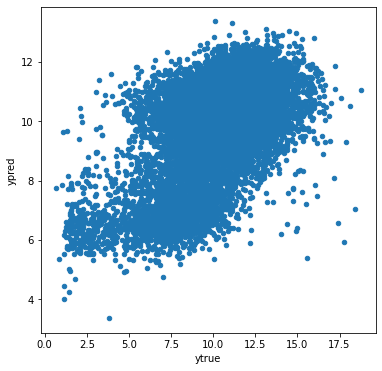

In [249]:
print(r2_score(df_eval2['ytrue'], df_eval2['ypred']))
df_eval2.plot.scatter('ytrue', 'ypred', figsize=(6, 6));

In [256]:
df_eval2.to_csv('../output/oof_kronecker_additive.csv', index=False)

In [257]:
!ls -lh ../output/

total 97G
-rw-r--r-- 1 igorf samuelbf 4.1G Jan 26 23:55 genotype.csv
-rw-r--r-- 1 igorf samuelbf 418M Jan 28 16:41 genotype.parquet
-rw-r--r-- 1 igorf samuelbf 445M Jan 26 19:36 kinship_additive.txt
-rw-r--r-- 1 igorf samuelbf  42G Jan 30 19:45 kronecker_additive_train.parquet
-rw-r--r-- 1 igorf samuelbf  51G Jan 30 20:16 kronecker_additive_val.parquet
-rw-r--r-- 1 igorf samuelbf 839K Jan 31 19:25 oof_kronecker_additive.csv
-rw-r--r-- 1 igorf samuelbf 839K Jan 31 15:34 oof_kronecker.csv
-rw-r--r-- 1 igorf samuelbf 908K Jan 31 15:32 oof_solution_4th_sub.csv
-rw-r--r-- 1 igorf samuelbf 581K Jan 26 21:49 submission_4th_sub.csv
-rw-r--r-- 1 igorf samuelbf  17K Jan 26 19:23 test_weather_features.csv
-rw-r--r-- 1 igorf samuelbf  18K Jan 26 19:23 train_weather_features.csv
-rw-r--r-- 1 igorf samuelbf  19K Jan 26 19:23 val_weather_features.csv
-rw-r--r-- 1 igorf samuelbf  14M Jan 26 21:49 xtest.csv
-rw-r--r-- 1 igorf samuelbf  13M Jan 26 21:49 xtrain.csv
-rw-r--r-- 1 igorf samuelbf  16M Jan 26

In [260]:
pd.concat([rmse_per_group, rmse_per_group2], axis=1)

,0,1
Env,,
COH1_2021,1.793489,3.569341
DEH1_2021,1.895454,2.021064
GAH1_2021,2.224581,2.155276
GAH2_2021,3.889274,2.258557
GEH1_2021,2.938794,2.282111
IAH1_2021,2.048194,2.359202
IAH2_2021,1.617109,1.357010
IAH3_2021,2.195066,2.043989
IAH4_2021,1.381125,1.667005
